With this script, the dynamics of the pathway genes were explored. The ones selected for ODE fitting are listed below.

1. Cell cycle arrest
2. Inflammation
3. Inflammation signalling

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import numpy as np
import seaborn as sns
import scanpy as sc
import scanpy.external as se
from itertools import product
import anndata as ad
import plotly.graph_objects as go
import matplotlib.cm as cm

sc.logging.print_versions()

-----
anndata     0.9.2
scanpy      1.9.5
-----
PIL                 9.4.0
asttokens           NA
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
bottleneck          1.3.5
colorama            0.4.6
comm                0.1.2
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.7
decorator           5.1.1
executing           0.8.3
h5py                3.9.0
hypergeom_ufunc     NA
igraph              0.10.8
invgauss_ufunc      NA
ipykernel           6.25.2
jedi                0.18.1
joblib              1.2.0
kiwisolver          1.4.4
llvmlite            0.40.1
louvain             0.8.1
matplotlib          3.7.2
matplotlib_inline   0.1.6
mkl                 2.4.0
mpl_toolkits        NA
natsort             8.4.0
nbinom_ufunc        NA
ncf_ufunc           NA
nct_ufunc           NA
ncx2_ufunc          NA
numba               0.57.1
numexpr             2.8.4
numpy               1.24.3
packaging           23.1
pandas           

Import and check data set that was already scored with senepy

In [16]:
adata = ad.read_h5ad('C://Users//Helene//Documents//Master_Thesis//TabulaMurisSenis//Data//all_sen_score_ec.h5ad')
adata.obs['cell_type'].value_counts()

cell_type
Kupffer cell                            1932
hepatocyte                              1614
endothelial cell of hepatic sinusoid     155
Name: count, dtype: int64

In [17]:
age_counts = adata.obs['age'].value_counts()
age_counts

age
30m    1773
3m     1021
18m     515
21m     289
24m     103
Name: count, dtype: int64

# Cell cycle arrest

In [18]:
gene_names = ['Map2k3','Mapk14', 'Trp53', 'Cdkn1a', 'Cdk4','Ccnd3', 'E2f4'] 
#gene_names = ['Map2k3','Mapk14', 'Trp53', 'Cdkn1a', 'E2f4']

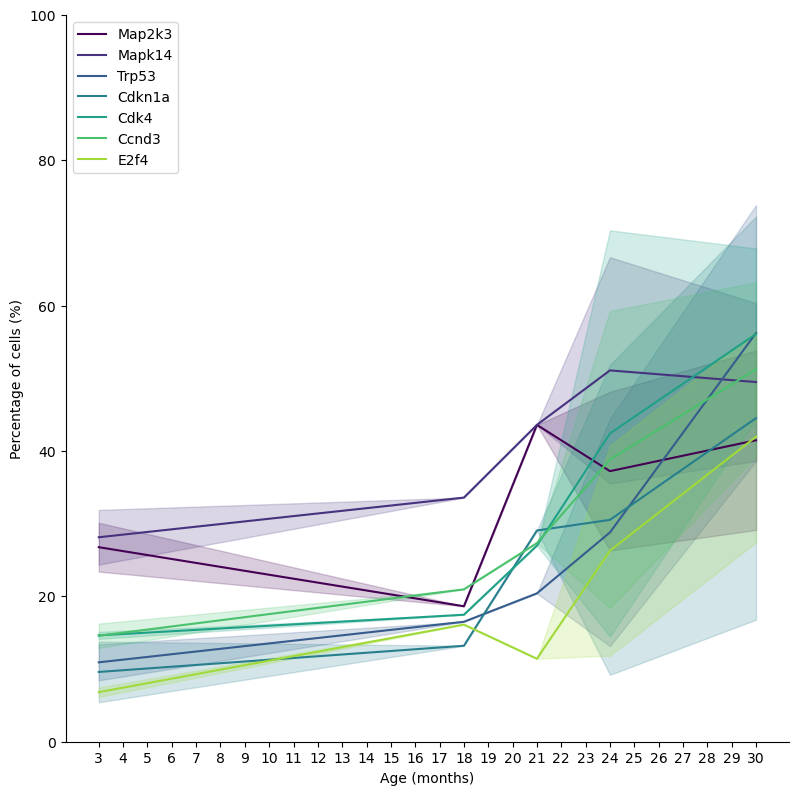

In [19]:
# ploting
fig, ax = plt.subplots(figsize=(8, 8))
colormap = cm.viridis
colorcount = 0
n = len(gene_names)

mouse_list = adata.obs['donor_id'].unique().tolist()
genes_per_age = pd.DataFrame(columns = ['Numeric_time'])
genes_per_mouse = pd.DataFrame(columns = ['Numeric_time'])
        
# selecting gene in dataset 
for gene_of_interest in gene_names:
    
    # extract numeric timepoints
    all_timepoints = adata.obs['age'].unique()
    timepoints_string = [str(timepoint) for timepoint in all_timepoints]
    timepoints_integer = [int(timepoint.split('m')[0]) for timepoint in timepoints_string]
    timepoints_sorted = [x for _, x in sorted(zip(timepoints_integer, all_timepoints))]

    adata_gene = adata[:, adata.var_names == gene_of_interest]
    expression_per_timepoint = pd.DataFrame(columns=['Gene', 'Timepoint', 'Numeric_time' ])

    # select timrpoint
    for timepoint in timepoints_sorted:
        adata_timepoint = adata_gene[adata_gene.obs['age'] == timepoint]
        expression_per_mouse =  pd.DataFrame(columns = ['Gene',  'Timepoint', 'Numeric_time' ])
        
        # select mouse
        for mouse in mouse_list:
            adata_mouse = adata_timepoint[adata_timepoint.obs['donor_id'] == mouse]    
            
            # make dataframe with gene expressions    
            expression_per_mouse.loc[0, 'Gene'] = gene_of_interest
            expression_per_mouse.loc[0, 'Timepoint'] = timepoint 
            expression_per_mouse['Numeric_time'] = expression_per_mouse['Timepoint'].str.split('m').str[0].astype(float)
            # calculate number of cells expressing the gene 
            expression_per_mouse[mouse] = (adata_mouse.X > 0).sum()
            # calculate total cells per mouse
            total_per_mouse = len(adata[adata.obs['donor_id'] == mouse])
            
            # calculate percentage of cells expressing the gene for cases with gene expression not 0
            if str(mouse).split('-')[0] == str(timepoint).split('m')[0] and expression_per_mouse[mouse].values[0] == 0:
                expression_per_mouse[mouse] = 0
            elif expression_per_mouse[mouse].values[0] == 0:
                    expression_per_mouse[mouse] = np.nan
            else: 
                expression_per_mouse[mouse] = expression_per_mouse[mouse] * 100 / total_per_mouse 

        # calculate mean for every timepoint (for case where there is more than 1 mouse)
        expression_per_mouse['Mean'] = expression_per_mouse.iloc[:, 3:].mean(axis=1)
        expression_per_mouse['Std'] = expression_per_mouse.iloc[:, 3:].std(axis=1)
        expression_per_timepoint = pd.concat([expression_per_timepoint, expression_per_mouse], ignore_index=True)
   
# plot resluts
    gene_data = expression_per_timepoint[expression_per_timepoint['Gene'] == gene_of_interest]
    x = gene_data['Numeric_time']
    y = gene_data['Mean']
    std = gene_data['Std']
    if colorcount <= n:
        colors = [colormap(colorcount / n) for colorcount in range(n)] 
        plt.plot(x, y, linestyle='-', label=gene_of_interest, color=colors[colorcount])
        plt.fill_between(x, y - std, y + std, alpha=0.2, color=colors[colorcount])
        colorcount += 1

plt.xticks(range(3,31))
plt.xlabel('Age (months)')
plt.ylabel('Percentage of cells (%)')
plt.legend(loc= 'upper left')
plt.tight_layout()
ax = plt.gca() 
ax.set_ylim([0, 100])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Inflammation

In [20]:
gene_names = ['Nr2c2', 'Tab2', 'Ikbkg', 'Chuk', 'Ikbkb', 'Nfkb1', 'Cdc37', 'Rela'] 

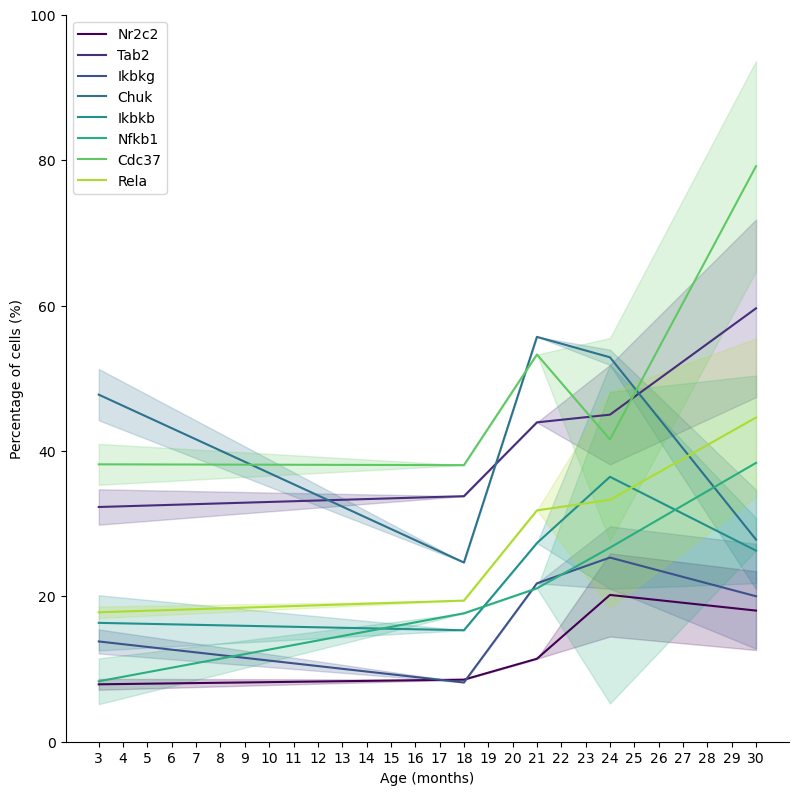

In [21]:
# ploting
fig, ax = plt.subplots(figsize=(8, 8))
colormap = cm.viridis
colorcount = 0
n = len(gene_names)

mouse_list = adata.obs['donor_id'].unique().tolist()
genes_per_age = pd.DataFrame(columns = ['Numeric_time'])
genes_per_mouse = pd.DataFrame(columns = ['Numeric_time'])
        
# selecting gene in dataset 
for gene_of_interest in gene_names:
    
    # extract numeric timepoints
    all_timepoints = adata.obs['age'].unique()
    timepoints_string = [str(timepoint) for timepoint in all_timepoints]
    timepoints_integer = [int(timepoint.split('m')[0]) for timepoint in timepoints_string]
    timepoints_sorted = [x for _, x in sorted(zip(timepoints_integer, all_timepoints))]

    adata_gene = adata[:, adata.var_names == gene_of_interest]
    expression_per_timepoint = pd.DataFrame(columns=['Gene', 'Timepoint', 'Numeric_time' ])

    # select timrpoint
    for timepoint in timepoints_sorted:
        adata_timepoint = adata_gene[adata_gene.obs['age'] == timepoint]
        expression_per_mouse =  pd.DataFrame(columns = ['Gene',  'Timepoint', 'Numeric_time' ])
        
        # select mouse
        for mouse in mouse_list:
            adata_mouse = adata_timepoint[adata_timepoint.obs['donor_id'] == mouse]    
            
            # make dataframe with gene expressions    
            expression_per_mouse.loc[0, 'Gene'] = gene_of_interest
            expression_per_mouse.loc[0, 'Timepoint'] = timepoint 
            expression_per_mouse['Numeric_time'] = expression_per_mouse['Timepoint'].str.split('m').str[0].astype(float)
            # calculate number of cells expressing the gene 
            expression_per_mouse[mouse] = (adata_mouse.X > 0).sum()
            # calculate total cells per mouse
            total_per_mouse = len(adata[adata.obs['donor_id'] == mouse])
            
            # calculate percentage of cells expressing the gene for cases with gene expression not 0
            if str(mouse).split('-')[0] == str(timepoint).split('m')[0] and expression_per_mouse[mouse].values[0] == 0:
                expression_per_mouse[mouse] = 0
            elif expression_per_mouse[mouse].values[0] == 0:
                    expression_per_mouse[mouse] = np.nan
            else: 
                expression_per_mouse[mouse] = expression_per_mouse[mouse] * 100 / total_per_mouse 

        # calculate mean for every timepoint (for case where there is more than 1 mouse)
        expression_per_mouse['Mean'] = expression_per_mouse.iloc[:, 3:].mean(axis=1)
        expression_per_mouse['Std'] = expression_per_mouse.iloc[:, 3:].std(axis=1)
        expression_per_timepoint = pd.concat([expression_per_timepoint, expression_per_mouse], ignore_index=True)

# plot resluts
    gene_data = expression_per_timepoint[expression_per_timepoint['Gene'] == gene_of_interest]
    x = gene_data['Numeric_time']
    y = gene_data['Mean']
    std = gene_data['Std']
    if colorcount <= n:
        colors = [colormap(colorcount / n) for colorcount in range(n)] 
        plt.plot(x, y, linestyle='-', label=gene_of_interest, color=colors[colorcount])
        plt.fill_between(x, y - std, y + std, alpha=0.2, color=colors[colorcount])
        colorcount += 1

plt.xticks(range(3,31))
plt.xlabel('Age (months)')
plt.ylabel('Percentage of cells (%)')
plt.legend(loc= 'upper left')
plt.tight_layout()
ax = plt.gca() 
ax.set_ylim([0, 100])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Inflammation signalling

In [22]:
gene_names = ['Ccl2', 'Ccl3', 'Ccl4', 'Ccl5', 'Cxcl2', 'Cxcl10'] 

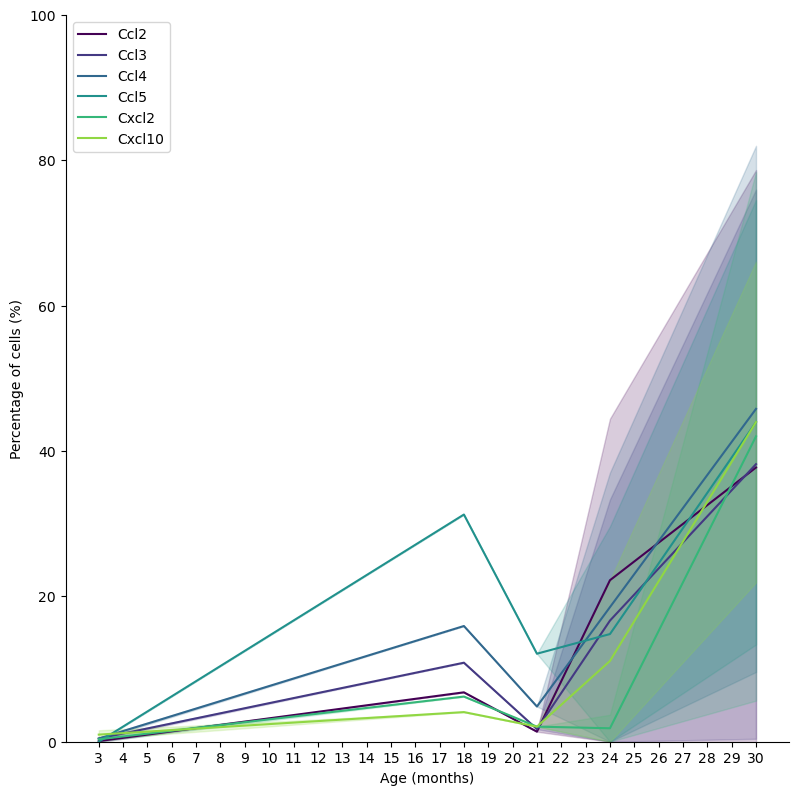

In [23]:
# ploting
fig, ax = plt.subplots(figsize=(8, 8))
colormap = cm.viridis
colorcount = 0
n = len(gene_names)

mouse_list = adata.obs['donor_id'].unique().tolist()
genes_per_age = pd.DataFrame(columns = ['Numeric_time'])
genes_per_mouse = pd.DataFrame(columns = ['Numeric_time'])
        
# selecting gene in dataset 
for gene_of_interest in gene_names:
    
    # extract numeric timepoints
    all_timepoints = adata.obs['age'].unique()
    timepoints_string = [str(timepoint) for timepoint in all_timepoints]
    timepoints_integer = [int(timepoint.split('m')[0]) for timepoint in timepoints_string]
    timepoints_sorted = [x for _, x in sorted(zip(timepoints_integer, all_timepoints))]

    adata_gene = adata[:, adata.var_names == gene_of_interest]
    expression_per_timepoint = pd.DataFrame(columns=['Gene', 'Timepoint', 'Numeric_time' ])

    # select timrpoint
    for timepoint in timepoints_sorted:
        adata_timepoint = adata_gene[adata_gene.obs['age'] == timepoint]
        expression_per_mouse =  pd.DataFrame(columns = ['Gene',  'Timepoint', 'Numeric_time' ])
        
        # select mouse
        for mouse in mouse_list:
            adata_mouse = adata_timepoint[adata_timepoint.obs['donor_id'] == mouse]    
            
            # make dataframe with gene expressions    
            expression_per_mouse.loc[0, 'Gene'] = gene_of_interest
            expression_per_mouse.loc[0, 'Timepoint'] = timepoint 
            expression_per_mouse['Numeric_time'] = expression_per_mouse['Timepoint'].str.split('m').str[0].astype(float)
            # calculate number of cells expressing the gene 
            expression_per_mouse[mouse] = (adata_mouse.X > 0).sum()
            # calculate total cells per mouse
            total_per_mouse = len(adata[adata.obs['donor_id'] == mouse])
            
            # calculate percentage of cells expressing the gene for cases with gene expression not 0
            if str(mouse).split('-')[0] == str(timepoint).split('m')[0] and expression_per_mouse[mouse].values[0] == 0:
                expression_per_mouse[mouse] = 0
            elif expression_per_mouse[mouse].values[0] == 0:
                    expression_per_mouse[mouse] = np.nan
            else: 
                expression_per_mouse[mouse] = expression_per_mouse[mouse] * 100 / total_per_mouse 

        # calculate mean for every timepoint (for case where there is more than 1 mouse)
        expression_per_mouse['Mean'] = expression_per_mouse.iloc[:, 3:].mean(axis=1)
        expression_per_mouse['Std'] = expression_per_mouse.iloc[:, 3:].std(axis=1)
        expression_per_timepoint = pd.concat([expression_per_timepoint, expression_per_mouse], ignore_index=True)

# plot resluts
    gene_data = expression_per_timepoint[expression_per_timepoint['Gene'] == gene_of_interest]
    x = gene_data['Numeric_time']
    y = gene_data['Mean']
    std = gene_data['Std']
    if colorcount <= n:
        colors = [colormap(colorcount / n) for colorcount in range(n)] 
        plt.plot(x, y, linestyle='-', label=gene_of_interest, color=colors[colorcount])
        plt.fill_between(x, y - std, y + std, alpha=0.2, color=colors[colorcount])
        colorcount += 1

plt.xticks(range(3,31))
plt.xlabel('Age (months)')
plt.ylabel('Percentage of cells (%)')
plt.legend(loc= 'upper left')
plt.tight_layout()
ax = plt.gca() 
ax.set_ylim([0, 100])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)